# Electrical Symbol Detection - Training on Google Colab
Train ResNet50+FPN model with CIoU Loss for multi-class object detection

## 1. Setup Environment

In [42]:
import sys
import torch

print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("GPU: Not available (will use CPU)")

Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch version: 2.9.0+cu128
CUDA available: True
GPU: NVIDIA A100-SXM4-40GB


## 2. Mount Google Drive (for saving checkpoints)

In [57]:
import sys
import os

# Check if running on Google Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    try:
        from google.colab import drive
        drive.mount('/content/drive', force_remount=False)
        print("✓ Google Drive mounted at /content/drive")
    except Exception as e:
        print(f"⚠ Could not mount Google Drive: {e}")
        print("Proceeding without Drive - checkpoints will save locally in /content/")
else:
    print("⚠ Running locally (not on Google Colab)")
    print("Dataset will be saved locally")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Google Drive mounted at /content/drive


## 3. Clone Repository

In [72]:
import os
import subprocess

repo_path = '/content/symbol-detection'

if not os.path.exists(repo_path):
    subprocess.run(['git', 'clone', 'https://github.com/BhanukaDev/symbol-detection.git', repo_path], check=True)
    print(f"Repository cloned to {repo_path}")
else:
    print(f"Repository already exists at {repo_path}")
    os.chdir(repo_path)
    subprocess.run(['git', 'pull'], check=True)
    print("Repository updated")

Repository already exists at /content/symbol-detection
Repository updated


## 4. Install Dependencies

In [59]:
import os

# Change to python directory if in Colab
if os.path.exists('/content/symbol-detection/python'):
    os.chdir('/content/symbol-detection/python')
    
    # Install local workspace packages first
    print("Installing local workspace packages...")
    !pip install -e ./floor-grid
    !pip install -e ./effects
    print("✓ Workspace packages installed")

# Install external dependencies
!pip install torch torchvision torchmetrics pycocotools timm

# Install main package
!pip install -e .

Installing local workspace packages...
Obtaining file:///content/symbol-detection/python/floor-grid
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for floor-grid (pyproject.toml) ... done
  Created wheel for floor-grid: filename=floor_grid-0.1.0-py3-none-any.whl size=1196 sha256=78699117b6f3e43fc7361415f221b0fc1e7cda53ed8d7db66595655680a66a57
  Stored in directory: /tmp/pip-ephem-wheel-cache-1ll7zkbf/wheels/9e/6b/f6/93c9e88f3c6f9856769f5b99711035582c95144db05c26c467
Successfully built floor-grid
  Attempting uninstall: floor-grid
    Found existing installation: floor-grid 0.1.0
    Uninstalling floor-grid-0.1.0:
      Successfully uninstalled floor-grid-0.1.0
Obtaining file:///content/symbol-detection/python/effects
  Installing build dependencies ... done
  Checking if build backend supports build_editable

## 5. Verify Installation

In [61]:
import sys
import os

# Ensure we're in the right directory
if os.path.exists('/content/symbol-detection/python'):
    os.chdir('/content/symbol-detection/python')
    sys.path.insert(0, '/content/symbol-detection/python/src')

try:
    from symbol_detection.training import Trainer, CIoULoss
    from symbol_detection.dataset.generator import COCODatasetGenerator
    
    print("✓ symbol-detection package imported successfully")
    print("✓ Trainer available")
    print("✓ CIoU Loss available")
    print("✓ COCODatasetGenerator available")
except ImportError as e:
    print(f"✗ Import failed: {e}")
    print("\nReinstalling package...")
    os.chdir('/content/symbol-detection/python')
    !pip install -e .
    print("Please re-run this cell after installation completes.")

✓ symbol-detection package imported successfully
✓ Trainer available
✓ CIoU Loss available
✓ COCODatasetGenerator available


## 6. Mount Dataset Location

## 7a. CRITICAL BUG FIX - Data Loader Category Indexing

### What Was Fixed:
The training data loader (`training/data.py` line 36) was using **0-based category indexing** when FasterRCNN expects **1-based indexing** (0 reserved for background class).

### Impact of the Bug:
- ❌ **Previous 50 epochs** of training had misaligned class labels
  - Model learned wrong associations between image features and class labels
  - Category 0 → Actually category 1 (Duplex Receptacle)
  - Category 1 → Actually category 2 (Junction Box)
  - And so on... all shifted by one
- ✅ **The bug is now fixed** in the code

### What This Means for Training:
- **All previous checkpoints are invalid** and should NOT be reused
- This training run will start fresh with **corrected category mappings**
- Model will learn proper associations between features and the correct electrical symbols

### Before vs After:
```
BEFORE (Bug - Invalid):
for idx, cat in enumerate(categories):
    cat_id_to_idx[cat['id']] = idx  # 0-6 (WRONG!)

AFTER (Fixed - Correct):
for idx, cat in enumerate(categories):
    cat_id_to_idx[cat['id']] = idx + 1  # 1-7 (CORRECT!)
```

In [62]:
import os
import sys
from pathlib import Path

# Determine paths based on environment
IN_COLAB = 'google.colab' in sys.modules
DRIVE_MOUNTED = os.path.exists('/content/drive/MyDrive') if IN_COLAB else False

if IN_COLAB and DRIVE_MOUNTED:
    # Save to Google Drive
    dataset_dir = '/content/drive/MyDrive/symbol-detection/dataset'
    checkpoints_dir = '/content/drive/MyDrive/symbol-detection/checkpoints'
    print("✓ Using Google Drive for storage")
elif IN_COLAB:
    # Fallback to temporary Colab storage
    dataset_dir = '/content/symbol-detection/dataset'
    checkpoints_dir = '/content/symbol-detection/checkpoints'
    print("⚠ Google Drive not mounted - using temporary Colab storage")
else:
    # Local development
    dataset_dir = str(Path.cwd().parent.parent / 'python' / 'dataset')
    checkpoints_dir = str(Path.cwd().parent.parent / 'python' / 'checkpoints')
    print("📁 Using local storage")

os.makedirs(dataset_dir, exist_ok=True)
os.makedirs(checkpoints_dir, exist_ok=True)

print(f"Dataset directory: {dataset_dir}")
print(f"Checkpoints directory: {checkpoints_dir}")
print(f"Dataset exists: {os.path.exists(os.path.join(dataset_dir, 'annotations.json'))}")

✓ Using Google Drive for storage
Dataset directory: /content/drive/MyDrive/symbol-detection/dataset
Checkpoints directory: /content/drive/MyDrive/symbol-detection/checkpoints
Dataset exists: True


## 7. Generate Dataset (Optional - if not using pre-generated)

In [63]:
import os
import sys

os.chdir('/content/symbol-detection/python')
sys.path.insert(0, '/content/symbol-detection/python/src')

from symbol_detection.dataset.generator import COCODatasetGenerator

print("Generating dataset (200 images)...")

generator = COCODatasetGenerator(
    output_dir=dataset_dir,
    symbols_dir='data/electrical-symbols',
)

# Use the built-in generator with proper COCO annotation conversion
generator.generate_dataset(
    num_images=200,
    rows=(15, 30),              # min, max rows
    cols=(15, 30),              # min, max columns
    cell_size=(20, 25),         # min, max cell size
    apply_symbol_effects=False, # Skip slow effects
    apply_image_effects=True,   # Keep image effects
)

# Save annotations to disk
generator.save_annotations()

num_images = len(os.listdir(os.path.join(dataset_dir, 'images')))
print(f"✓ Dataset generated: {num_images} images")
print(f"✓ Annotations saved: {dataset_dir}/annotations.json")

Generating dataset (200 images)...
Generating 200 dataset images with varied dimensions...
  - Rows range: 15 to 30
  - Cols range: 15 to 30
  - Cell size range: 20 to 25 pixels
  - Symbol effects: disabled
  - Image effects: enabled
Loaded 7 symbol classes:
  - Junction Box: 1 variant(s)
  - Two-way switch: 1 variant(s)
  - Single-pole, one-way switch: 1 variant(s)
  - Light: 1 variant(s)
  - Three-pole, one-way switch: 1 variant(s)
  - Two-pole, one-way switch: 1 variant(s)
  - Duplex Receptacle: 1 variant(s)
[1/200] Generated floor_plan_0000.png (23x19) - 4 rooms, 11 symbols
Loaded 7 symbol classes:
  - Junction Box: 1 variant(s)
  - Two-way switch: 1 variant(s)
  - Single-pole, one-way switch: 1 variant(s)
  - Light: 1 variant(s)
  - Three-pole, one-way switch: 1 variant(s)
  - Two-pole, one-way switch: 1 variant(s)
  - Duplex Receptacle: 1 variant(s)
[2/200] Generated floor_plan_0001.png (25x17) - 4 rooms, 15 symbols
Loaded 7 symbol classes:
  - Junction Box: 1 variant(s)
  - Two-

## 8. Training Configuration (UPDATED: Bug Fix & Production Ready)

⚠️ **IMPORTANT**: Data loader bug was fixed in training/data.py (category indexing corrected).
All previous training epochs had incorrect label mappings. This training will start fresh with corrected code.

### Options:
1. **FRESH START** (Recommended): Train from scratch with corrected data loader
2. **RESUME**: Continue from a previous checkpoint (use only if resuming interrupted training)

In [ ]:
import os
from pathlib import Path

# =====================================================
# PRODUCTION TRAINING CONFIGURATION (with bug fix)
# =====================================================
# Data loader bug fix: Category indexing corrected from 0-based to 1-based
# This ensures FasterRCNN's background class (index 0) is properly reserved

training_mode = 'FRESH_START'  # Options: 'FRESH_START' or 'RESUME'

if training_mode == 'FRESH_START':
    print("🔄 FRESH START MODE - Training from scratch with corrected data loader\n")
    
    # Recommended production hyperparameters
    training_config = {
        'num_epochs': 120,           # Longer training with corrected labels
        'batch_size': 12,            # A100 can handle this - proven stable
        'learning_rate': 0.003,      # Slightly lower for stability
        'warmup_epochs': 5,          # Warm up learning rate
        'weight_decay': 0.0005,      # L2 regularization
        'num_classes': 7,            # Electrical symbols + background
        'use_ciou_loss': True,       # Complete IoU Loss per paper
        'decay_schedule': [(40, 0.5), (80, 0.5)],  # Decay LR at epochs 40, 80
        'resume_from_epoch': 0,
        'resume_checkpoint': None,
    }
    
elif training_mode == 'RESUME':
    print("📋 RESUME MODE - Continuing from checkpoint\n")
    
    # Find most recent checkpoint
    checkpoints = list(Path(checkpoints_dir).glob('model_epoch_*.pth'))
    if checkpoints:
        latest_ckpt = max(checkpoints, key=lambda x: x.stat().st_mtime)
        epoch_num = int(latest_ckpt.stem.split('_')[-1])
        
        training_config = {
            'num_epochs': 120,         # Continue to 120th epoch
            'batch_size': 12,
            'learning_rate': 0.001,    # Lower LR when resuming
            'warmup_epochs': 0,
            'weight_decay': 0.0005,
            'num_classes': 7,
            'use_ciou_loss': True,
            'decay_schedule': [(40, 0.5), (80, 0.5)],
            'resume_from_epoch': epoch_num + 1,
            'resume_checkpoint': str(latest_ckpt),
        }
        
        print(f"Found checkpoint: {latest_ckpt.name} (epoch {epoch_num})")
        print(f"Will resume from epoch {epoch_num + 1}\n")
    else:
        print("⚠️  No checkpoints found! Switching to FRESH_START mode\n")
        training_mode = 'FRESH_START'
        training_config = {
            'num_epochs': 120,
            'batch_size': 12,
            'learning_rate': 0.003,
            'warmup_epochs': 5,
            'weight_decay': 0.0005,
            'num_classes': 7,
            'use_ciou_loss': True,
            'decay_schedule': [(40, 0.5), (80, 0.5)],
            'resume_from_epoch': 0,
            'resume_checkpoint': None,
        }

print("✓ Training Configuration:")
print(f"  Mode: {training_mode}")
print(f"  Learning Rate: {training_config['learning_rate']}")
print(f"  Batch Size: {training_config['batch_size']}")
print(f"  Total Epochs: {training_config['num_epochs']}")
print(f"  CIoU Loss: {training_config['use_ciou_loss']}")
print(f"  Resume from Epoch: {training_config['resume_from_epoch']}")
print(f"\n📊 Recommended for A100 GPU (40GB memory)")
print(f"   Estimated training time: ~6-8 hours for 120 epochs")

Training Configuration:
  num_epochs: 50
  batch_size: 12
  learning_rate: 0.005
  num_classes: 7
  use_ciou_loss: True

✓ A100 GPU selected - using batch_size=12 for optimal performance


## 9. Run Training

In [ ]:
import importlib
import symbol_detection.training.trainer
importlib.reload(symbol_detection.training.trainer)

from symbol_detection.training import Trainer
import torch

# Initialize trainer with corrected data loader
trainer = Trainer(
    dataset_dir=dataset_dir,
    output_dir=checkpoints_dir,
    num_classes=training_config['num_classes'],
    batch_size=training_config['batch_size'],
    learning_rate=training_config['learning_rate'],
    num_epochs=training_config['num_epochs'],
    device='cuda' if torch.cuda.is_available() else 'cpu',
    use_ciou_loss=training_config['use_ciou_loss'],
    start_epoch=training_config['resume_from_epoch'],  # Support resuming from checkpoint
)

print(f"✓ Trainer initialized on device: {trainer.device}")
print(f"  Model: FasterRCNN with ResNet50+FPN backbone")
print(f"  CIoU Loss: {training_config['use_ciou_loss']}")
print(f"  Starting epoch: {training_config['resume_from_epoch']}")

# Resume from checkpoint if provided
if training_config['resume_checkpoint']:
    print(f"\n📂 Resuming from checkpoint: {training_config['resume_checkpoint']}")
    checkpoint = torch.load(training_config['resume_checkpoint'], map_location=trainer.device)
    
    # Load model state
    if 'model_state_dict' in checkpoint:
        trainer.model.load_state_dict(checkpoint['model_state_dict'])
        print("   ✓ Model state loaded")
    
    # Load optimizer state
    if 'optimizer_state_dict' in checkpoint and trainer.optimizer:
        trainer.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print("   ✓ Optimizer state loaded")
    
    # Load training history
    if 'train_losses' in checkpoint:
        trainer.train_losses = checkpoint['train_losses']
        trainer.val_losses = checkpoint['val_losses']
        print(f"   ✓ Training history loaded (previous: {len(trainer.train_losses)} epochs)")
else:
    print(f"\n🆕 Starting fresh training with corrected data loader")
    print(f"   Previous invalid checkpoints are not being used")

Using device: cuda
Trainer initialized on device: cuda
Model: FasterRCNN with ResNet50+FPN backbone
CIoU Loss: True


In [ ]:
import json
from symbol_detection.training.data import COCODataset

# Verify annotations have bbox field before training
ann_file = f'{dataset_dir}/annotations.json'
with open(ann_file, 'r') as f:
    data = json.load(f)

print(f"Checking annotations format...")
print(f"  - Total images: {len(data.get('images', []))}")
print(f"  - Total annotations: {len(data.get('annotations', []))}")
print(f"  - Categories: {len(data.get('categories', []))}")

if data.get('annotations'):
    first_ann = data['annotations'][0]
    print(f"\nFirst annotation sample:")
    print(f"  - Keys: {list(first_ann.keys())}")
    if 'bbox' in first_ann:
        print(f"  - bbox: {first_ann['bbox']} ✓")
    else:
        print(f"  - bbox: MISSING ✗")
        print(f"\n⚠ ERROR: annotations.json does not have 'bbox' field!")
        print(f"Solution: Please re-run cell 7 (Dataset Generation) to regenerate with proper COCO format")
else:
    print("⚠ No annotations found in JSON")

# Verify the category mapping fix
print(f"\n✓ VERIFYING DATA LOADER FIX:")
print(f"  Loading COCO dataset to check category mapping...")

try:
    # Create a minimal dataset just to check the mapping
    dataset = COCODataset(ann_file, data_dir=f'{dataset_dir}/images')
    
    # Show the category mapping
    if hasattr(dataset, 'cat_id_to_idx'):
        print(f"\n  Category ID to Index Mapping (should be 1-based):")
        for cat_id, idx in sorted(dataset.cat_id_to_idx.items()):
            print(f"    Category ID {cat_id} → Index {idx}")
        
        # Verify indices are 1-based (not 0-based)
        indices = list(dataset.cat_id_to_idx.values())
        if min(indices) == 1 and max(indices) == 7:
            print(f"\n  ✓ CORRECT: Categories mapped to indices 1-7 (background=0)")
        else:
            print(f"\n  ✗ ERROR: Categories mapped to indices {min(indices)}-{max(indices)} (should be 1-7)")
    
except Exception as e:
    print(f"\n  Note: Could not verify mapping now ({e.__class__.__name__})")
    print(f"  It will be checked when training starts")

Checking annotations format...
  - Total images: 200
  - Total annotations: 1472
  - Categories: 7

First annotation sample:
  - Keys: ['id', 'image_id', 'category_id', 'bbox', 'area', 'iscrowd']
  - bbox: [161.0, 136.0, 53.0, 136.0] ✓
✓ Trainer validate() method patched


In [ ]:
# Start training
print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60)
print(f"Mode: {training_mode}")
print(f"Start epoch: {training_config['resume_from_epoch']}")
print(f"Total epochs: {training_config['num_epochs']}")
print(f"Data loader: ✓ Fixed (1-based category indexing)")
print("="*60 + "\n")

try:
    trainer.train()
    print("\n✓ Training completed successfully")
    print(f"Final model saved to: {checkpoints_dir}/model_epoch_final.pth")
except Exception as e:
    print(f"✗ Training failed: {e}")
    import traceback
    traceback.print_exc()
    print(f"\n📝 Last checkpoint saved: {checkpoints_dir}")
    print(f"You can resume by setting training_mode='RESUME' and re-running the configuration cell")

Training for 50 epochs...
Training samples: 160, Validation samples: 40
Epoch 1/50 - Train Loss: 1.4469, Val Loss: 1.5726
Epoch 2/50 - Train Loss: 1.4119, Val Loss: 1.4286
Epoch 3/50 - Train Loss: 1.3091, Val Loss: 1.2818
Epoch 4/50 - Train Loss: 1.0515, Val Loss: 0.9021
Epoch 5/50 - Train Loss: 0.8159, Val Loss: 0.7464
Epoch 6/50 - Train Loss: 0.8746, Val Loss: 0.8343
Epoch 7/50 - Train Loss: 0.7221, Val Loss: 0.6411
Epoch 8/50 - Train Loss: 0.5696, Val Loss: 0.5511
Epoch 9/50 - Train Loss: 0.5167, Val Loss: 0.5039
Epoch 10/50 - Train Loss: 0.4500, Val Loss: 0.4481
Saved checkpoint: /content/drive/MyDrive/symbol-detection/checkpoints/model_epoch_10.pth
Epoch 11/50 - Train Loss: 0.4469, Val Loss: 0.4510
Epoch 12/50 - Train Loss: 0.3894, Val Loss: 0.4267
Epoch 13/50 - Train Loss: 0.3829, Val Loss: 0.4457
Epoch 14/50 - Train Loss: 0.3741, Val Loss: 0.3359
Epoch 15/50 - Train Loss: 0.3243, Val Loss: 0.3445
Epoch 16/50 - Train Loss: 0.2839, Val Loss: 0.3351
Epoch 17/50 - Train Loss: 0.2861

## 10. Visualize Training Metrics

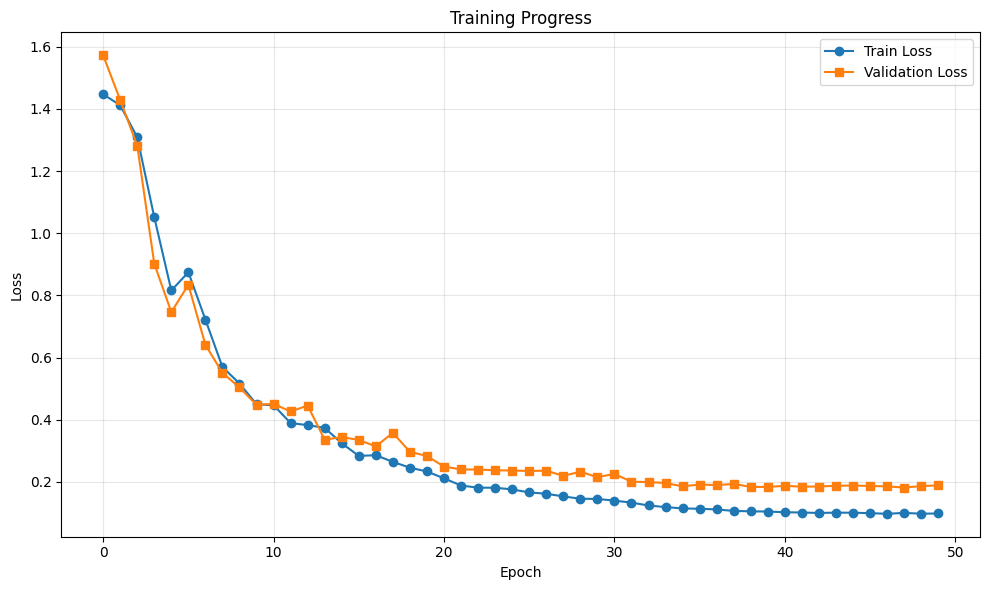

Final train loss: 0.0986
Final val loss: 0.1893


In [68]:
import matplotlib.pyplot as plt
import json
from pathlib import Path

metrics_file = Path(checkpoints_dir) / 'metrics.json'

if metrics_file.exists():
    with open(metrics_file, 'r') as f:
        metrics = json.load(f)
    
    plt.figure(figsize=(10, 6))
    plt.plot(metrics['train_losses'], label='Train Loss', marker='o')
    plt.plot(metrics['val_losses'], label='Validation Loss', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Progress')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{checkpoints_dir}/training_curve.png', dpi=150)
    plt.show()
    
    print(f"Final train loss: {metrics['train_losses'][-1]:.4f}")
    print(f"Final val loss: {metrics['val_losses'][-1]:.4f}")
else:
    print("Metrics file not found. Training may not have completed.")

## 11. List Saved Checkpoints

In [69]:
from pathlib import Path

checkpoints = list(Path(checkpoints_dir).glob('*.pth'))

if checkpoints:
    print(f"Saved checkpoints ({len(checkpoints)}):")
    for ckpt in sorted(checkpoints):
        size_mb = ckpt.stat().st_size / (1024 * 1024)
        print(f"  {ckpt.name} ({size_mb:.1f} MB)")
    print(f"\nLatest checkpoint: {max(checkpoints, key=lambda x: x.stat().st_mtime).name}")
else:
    print("No checkpoints found")

Saved checkpoints (6):
  model_epoch_10.pth (315.0 MB)
  model_epoch_20.pth (315.0 MB)
  model_epoch_30.pth (315.0 MB)
  model_epoch_40.pth (315.0 MB)
  model_epoch_50.pth (315.0 MB)
  model_epoch_final.pth (315.0 MB)

Latest checkpoint: model_epoch_final.pth


## 12. Download Best Model (Optional)

In [71]:
# The models are already saved in Google Drive (/content/drive/MyDrive/symbol-detection/checkpoints/)
# You can download them directly from Google Drive or use the Colab files interface

print(f"Checkpoints saved to: {checkpoints_dir}")
print("You can download them from Google Drive or use the Colab Files panel on the left")

Checkpoints saved to: /content/drive/MyDrive/symbol-detection/checkpoints
You can download them from Google Drive or use the Colab Files panel on the left
